In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch import nn as nn
import numpy as np
import matplotlib.pyplot as plt
from conditional_VAE import conditional_VAE, loss_function

/workspace/qing/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

Selected device: cuda


In [3]:
path = "cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = torch.from_numpy(np.load(path + "colored_mnist_init_train.npy"))
mnist_test = torch.from_numpy(np.load(path + "colored_mnist_init_test.npy"))
mnist_train_target = torch.from_numpy(np.load(path + "colored_mnist_target_train.npy"))
mnist_test_target = torch.from_numpy(np.load(path + "colored_mnist_target_test.npy"))

print(mnist_train.shape, mnist_test.shape, mnist_train.dtype)
print(mnist_train_target.shape, mnist_test_target.shape, mnist_train_target.dtype)

batch_size = 128
train_dataset = TensorDataset(mnist_train, mnist_train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(mnist_test, mnist_test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

torch.Size([60000, 3, 28, 28]) torch.Size([10000, 3, 28, 28]) torch.float32
torch.Size([60000, 7]) torch.Size([10000, 7]) torch.float32


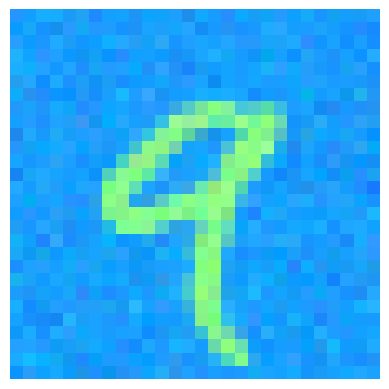

In [4]:
plt.figure(1)
plt.imshow(mnist_train[4, :, :, :].permute(1, 2, 0))
plt.axis("off")
plt.show()

In [5]:
VAE = conditional_VAE(
    shape=(3, 28, 28), latent_dim=32, label_dim=mnist_train_target.shape[1]
)
# VAE = nn.DataParallel(VAE)
VAE.to(device)

optimizer = optim.Adam(VAE.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

In [6]:
num_epochs = 50

for epoch in range(num_epochs):
    VAE.train()
    train_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=False):
            x_hat, mean, logvar = VAE(x, y)
            loss = loss_function(x, x_hat, mean, logvar)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader.dataset)

    VAE.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=False):
                x_hat, mean, logvar = VAE(x, y)
                loss = loss_function(x, x_hat, mean, logvar)

            val_loss += loss.item()
    val_loss = val_loss / len(test_loader.dataset)

    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )


 EPOCH 1/50 	 train loss 86.546 	 val loss 126.443

 EPOCH 2/50 	 train loss 50.730 	 val loss 108.144

 EPOCH 3/50 	 train loss 40.384 	 val loss 99.931

 EPOCH 4/50 	 train loss 35.286 	 val loss 89.808

 EPOCH 5/50 	 train loss 31.996 	 val loss 87.963

 EPOCH 6/50 	 train loss 29.848 	 val loss 81.330

 EPOCH 7/50 	 train loss 28.315 	 val loss 81.248

 EPOCH 8/50 	 train loss 27.217 	 val loss 82.942

 EPOCH 9/50 	 train loss 26.342 	 val loss 82.135

 EPOCH 10/50 	 train loss 25.655 	 val loss 81.869

 EPOCH 11/50 	 train loss 25.144 	 val loss 81.304

 EPOCH 12/50 	 train loss 24.695 	 val loss 77.498

 EPOCH 13/50 	 train loss 24.280 	 val loss 78.068

 EPOCH 14/50 	 train loss 23.903 	 val loss 77.754

 EPOCH 15/50 	 train loss 23.557 	 val loss 77.993

 EPOCH 16/50 	 train loss 23.200 	 val loss 78.322

 EPOCH 17/50 	 train loss 22.891 	 val loss 78.550

 EPOCH 18/50 	 train loss 22.705 	 val loss 78.424

 EPOCH 19/50 	 train loss 22.520 	 val loss 78.951

 EPOCH 20/50 	 tra

In [7]:
def plot_reconstructed_images(
    train_data: torch.Tensor, train_label: torch.Tensor, num_images=5
):
    with torch.no_grad():
        reconstructed_image, _, _ = VAE(
            train_data[:num_images, :, :, :].to(device),
            train_label[:num_images, :].to(device),
        )
        reconstructed_image = reconstructed_image.cpu().permute(0, 2, 3, 1)

        fig = plt.figure(constrained_layout=True, figsize=(12, 5))
        subfigs = fig.subfigures(nrows=2, ncols=1)
        for row, subfig in enumerate(subfigs):
            if row == 0:
                subfig.suptitle("Reconstructed Images")
            elif row == 1:
                subfig.suptitle("Original Images")

            axs = subfig.subplots(nrows=1, ncols=num_images)
            for col, ax in enumerate(axs):
                if row == 0:
                    ax.imshow(reconstructed_image[col, :, :, :])
                    ax.axis("off")
                elif row == 1:
                    ax.imshow(train_data[col, :, :, :].permute(1, 2, 0))
                    ax.axis("off")

        fig.show()

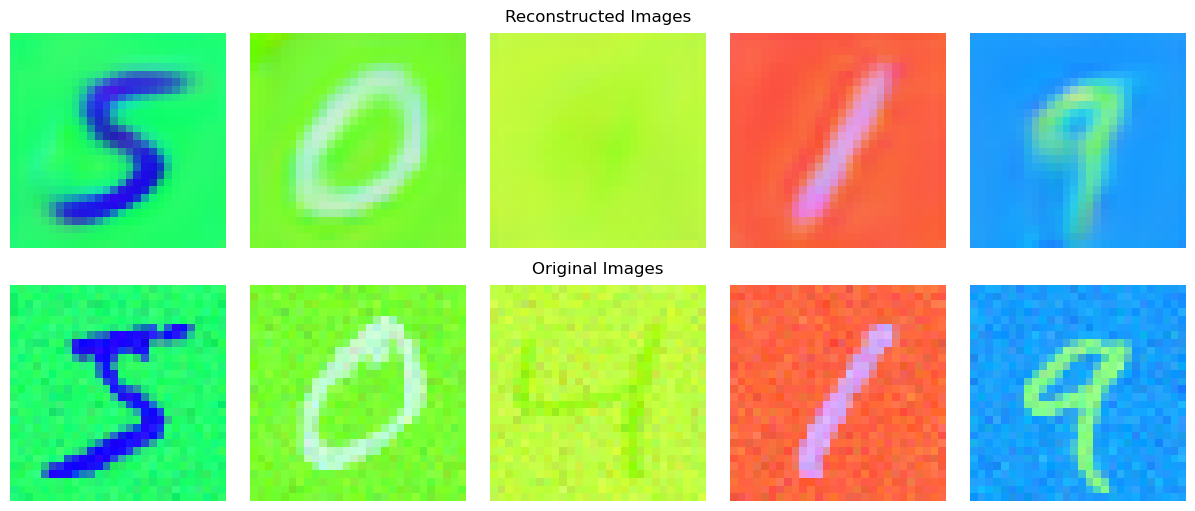

In [8]:
num_images = 5
VAE.eval()

plot_reconstructed_images(mnist_train, mnist_train_target, num_images=num_images)

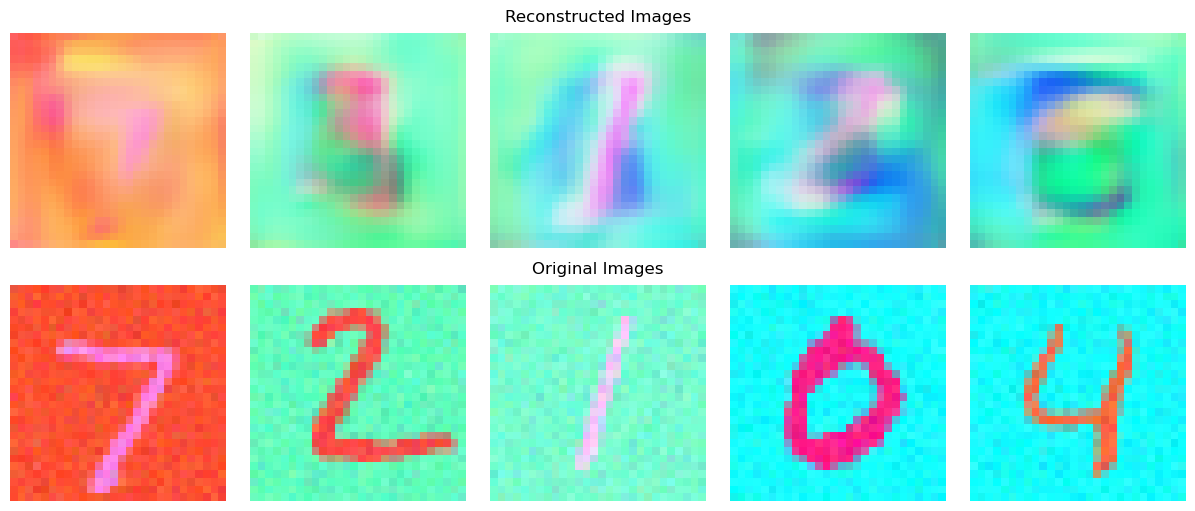

In [9]:
plot_reconstructed_images(mnist_test, mnist_test_target, num_images=num_images)

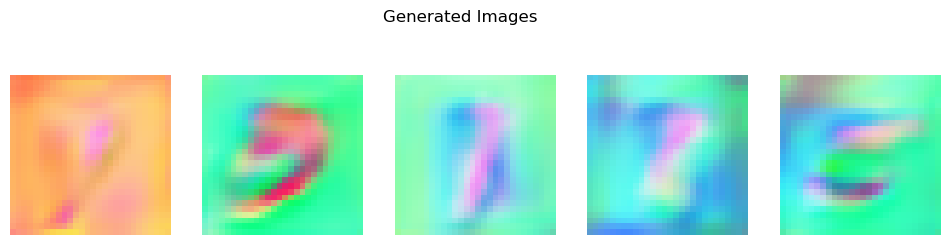

In [10]:
with torch.no_grad():
    condition = mnist_test_target[:num_images, :]
    generated_images = VAE.generate(condition.to(device), num_data=num_images)
    generated_images = generated_images.cpu().permute(0, 2, 3, 1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis("off")

    plt.suptitle("Generated Images")
    plt.show()